In [1]:
import numpy as np
import tqdm
import sklearn.metrics
import json
import pickle
import pandas as pd
import torch
import cv2
from pathlib import Path
from collections import Counter
from pprint import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from torchmetrics.functional import auroc

## Comparing CORN survival probabilities with old setup
setup

In [2]:
def load_predictions(hiddens_dir, run_name):
    probs = []
    golds = []
    preds = []
    exams = []
    censors = []
    for i, path in enumerate(Path(hiddens_dir, run_name).glob('*.predictions')):
        p = pickle.load(open(str(path), 'rb'))
        
        probs.append(p['probs'])
        golds.append(p['golds'])
        exams.append(p['exam'])
        censors.append(p['censors'])
    
    censors = torch.stack(censors)
    probs = torch.stack(probs)
    golds = torch.stack(golds)
    exams = torch.stack(exams)
    return {
        'probs': probs,
        'golds': golds,
        'exams': exams,
        'censors': censors
    }


load metadata

In [3]:
DATASET_PATH = '/Mounts/rbg-storage1/datasets/PLCO_XRAY/metadata_2022_04_05_rotated.json'
metadata = json.load(open(DATASET_PATH, 'r'))
exam2pid = {}
exam2split = {}
for p in tqdm(metadata):
    pid = p['pid']
    for e in p['accessions']:
        study_yr = e['study_yr']
        
        pid_int = int( str(ord(pid[0])) + ''.join(c for c in pid if c.isdigit()) )
        exam_int = int(f"{int(pid_int)}{int(study_yr)}")
        
        exam2pid[exam_int] = pid
        exam2split[exam_int] = p['split']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 130196.43it/s]


load predictions

In [6]:
HIDDENS_DIR = '/Mounts/rbg-storage1/users/ludvig/SybilX/hiddens/test_run'
corn_predictions = load_predictions(HIDDENS_DIR, '844c5292df5cc3369ed622042d95d1f6')
old_predictions = load_predictions(HIDDENS_DIR, '4f2cbb60b33af45749d3074e2933bc4d')
test_predictions = load_predictions(HIDDENS_DIR, '32d0ce59e9b77b1ee88aae769b01a0ea')

PLCO x-rays

In [39]:
corn_probs = corn_predictions['probs']
old_probs = old_predictions['probs']


(array([8.312e+03, 4.803e+03, 2.109e+03, 8.970e+02, 3.830e+02, 1.670e+02,
        6.300e+01, 2.600e+01, 9.000e+00, 8.000e+00]),
 array([0.00255324, 0.02058749, 0.03862175, 0.056656  , 0.07469025,
        0.09272451, 0.11075876, 0.12879302, 0.14682727, 0.16486153,
        0.18289578], dtype=float32),
 <BarContainer object of 10 artists>)

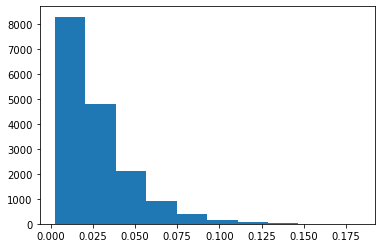

In [53]:
df = pd.DataFrame(corn_probs)

for i in range(len(df.columns)-1):
    df[str(i)+"->"+str(i+1)] = df[i+1] - df[i]
    
plt.hist(df["0->1"])

In [58]:
df[list(range(12))].std()

0     0.025512
1     0.046539
2     0.066941
3     0.082059
4     0.093690
5     0.100780
6     0.106540
7     0.110754
8     0.111706
9     0.108179
10    0.096405
11    0.075181
dtype: float32

<BarContainer object of 12 artists>

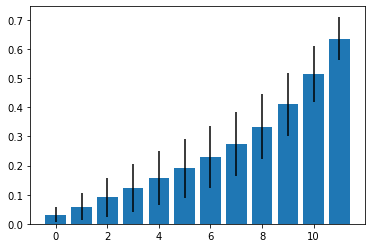

In [61]:
plt.bar(range(12), df[list(range(12))].mean(), yerr=df[list(range(12))].std())

In [37]:
# TODO: visualize histograms of differences between year-1 to year-2, year3 to year2, etc.

(array([    0.,     0.,     0.,     0.,     0., 16777.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

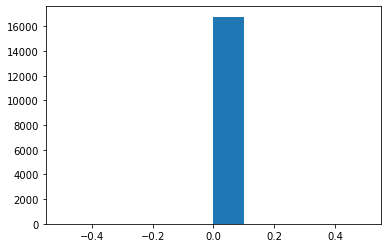

In [63]:
df = pd.DataFrame(old_probs)

for i in range(len(df.columns)-1):
    df[str(i)+"->"+str(i+1)] = df[i+1] - df[i]

plt.hist(df["3->4"])

<BarContainer object of 12 artists>

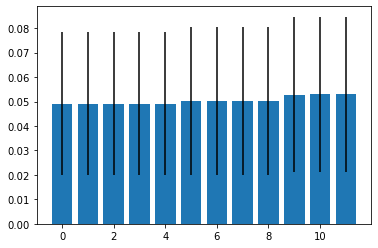

In [67]:
# TODO: visualize bar chart with stdevs of each year
plt.bar(range(12), df[list(range(12))].mean(), yerr=df[list(range(12))].std())

In [3]:
import sys
import os

In [4]:
sys.path.append('/Mounts/rbg-storage1/users/ludvig/SybilX')

In [8]:
from argparse import Namespace

In [6]:
from sybilx.datasets.plco_xray import PLCO_XRay_Dataset

In [29]:
args = Namespace(
    max_followup=12,
    dataset_file_path='/Mounts/rbg-storage1/datasets/PLCO_XRAY/metadata_2022_04_05_rotated.json',
    train_rawinput_augmentations=[],
    train_tnsr_augmentations=[],
    test_rawinput_augmentations=[],
    test_tnsr_augmentations=[],
    input_loader_name='tif_loader',
    cache_path='.',
    loss_fns=['survival'],
    split_type='random',
    assign_splits=True,
    cross_val_seed=0,
    split_probs=[0.7,0.15,0.15],
    plco_train_study_yrs=None,
    plco_test_study_yrs=None,
    plco_use_only_visitnum=None,
    plco_use_only_one_image=None,
    min_img_width=None,
    max_img_width=None,
    min_img_height=None,
    max_img_height=None,
    use_risk_factors=False,
    class_bal=True,
    class_bal_key='y'
)
train_data = PLCO_XRay_Dataset(args, 'train')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 25930.56it/s]

Contructed PLCO X-Ray Cancer Risk train dataset with 63005 records, 59098 exams, 17524 patients, and the following class balance 
 Counter({0: 60822, 1: 2183})
Censor Times: Counter({11: 28063, 10: 9040, 9: 8012, 8: 6381, 7: 4045, 6: 2135, 5: 1247, 3: 913, 4: 907, 2: 877, 1: 754, 0: 631})
Class counts are: Counter({0: 60822, 1: 2183})
Label weights are {0: 8.220709611653678e-06, 1: 0.00022904260192395785}


In [30]:
dev_data = PLCO_XRay_Dataset(args, 'dev')
test_data =  PLCO_XRay_Dataset(args, 'test')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 110051.02it/s]


Contructed PLCO X-Ray Cancer Risk dev dataset with 13241 records, 12395 exams, 3683 patients, and the following class balance 
 Counter({0: 12786, 1: 455})
Censor Times: Counter({11: 5906, 10: 1849, 9: 1688, 8: 1361, 7: 908, 6: 485, 5: 233, 4: 189, 3: 175, 2: 163, 1: 149, 0: 135})
Class counts are: Counter({0: 12786, 1: 455})
Label weights are {0: 3.9105271390583454e-05, 1: 0.001098901098901099}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 103980.21it/s]

Contructed PLCO X-Ray Cancer Risk test dataset with 13416 records, 12609 exams, 3763 patients, and the following class balance 
 Counter({0: 12920, 1: 496})
Censor Times: Counter({11: 5812, 10: 1907, 9: 1739, 8: 1383, 7: 879, 6: 517, 5: 279, 2: 199, 4: 186, 0: 173, 1: 171, 3: 171})
Class counts are: Counter({0: 12920, 1: 496})
Label weights are {0: 3.869969040247678e-05, 1: 0.0010080645161290322}


In [43]:
sample['y_mask']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [57]:
pos_at_12 = 0
neg_at_12 = 0

for sample in train_data.dataset + dev_data.dataset + test_data.dataset:
    #if sample['y_mask'][10] == 1 and not (sample['y_mask'][11] == 1):
    if sample['y']:
        pos_at_12 += 1
    else:
        neg_at_12 += 1

pos_at_12, neg_at_12, pos_at_12/neg_at_12

(3134, 86528, 0.03621948964497041)

In [59]:
for p in metadata:
    for e in p['accessions']:
        break
        

In [64]:
p['pt_metadata']['lung_exitdays']

4251

trying to make new survival similar to binary

In [8]:
df

,0,1,2,3,4,5,6,7,8,9,...,1->2,2->3,3->4,4->5,5->6,6->7,7->8,8->9,9->10,10->11
0,tensor(0.0229),tensor(0.0454),tensor(0.0713),tensor(0.1042),tensor(0.1320),tensor(0.1669),tensor(0.1999),tensor(0.2390),tensor(0.2786),tensor(0.3251),...,tensor(0.0258),tensor(0.0330),tensor(0.0278),tensor(0.0349),tensor(0.0330),tensor(0.0391),tensor(0.0396),tensor(0.0465),tensor(0.0367),tensor(0.0347)
1,tensor(0.0222),tensor(0.0449),tensor(0.0702),tensor(0.1042),tensor(0.1323),tensor(0.1684),tensor(0.2035),tensor(0.2433),tensor(0.2849),tensor(0.3340),...,tensor(0.0254),tensor(0.0339),tensor(0.0282),tensor(0.0361),tensor(0.0351),tensor(0.0398),tensor(0.0416),tensor(0.0491),tensor(0.0400),tensor(0.0394)
2,tensor(0.0350),tensor(0.0696),tensor(0.1051),tensor(0.1473),tensor(0.1815),tensor(0.2204),tensor(0.2579),tensor(0.2968),tensor(0.3351),tensor(0.3756),...,tensor(0.0355),tensor(0.0421),tensor(0.0342),tensor(0.0390),tensor(0.0375),tensor(0.0388),tensor(0.0383),tensor(0.0405),tensor(0.0333),tensor(0.0298)
3,tensor(0.0564),tensor(0.1084),tensor(0.1625),tensor(0.2208),tensor(0.2629),tensor(0.3093),tensor(0.3511),tensor(0.3908),tensor(0.4284),tensor(0.4608),...,tensor(0.0540),tensor(0.0583),tensor(0.0421),tensor(0.0464),tensor(0.0418),tensor(0.0397),tensor(0.0377),tensor(0.0324),tensor(0.0320),tensor(0.0242)
4,tensor(0.0291),tensor(0.0577),tensor(0.0897),tensor(0.1287),tensor(0.1607),tensor(0.2011),tensor(0.2397),tensor(0.2820),tensor(0.3262),tensor(0.3737),...,tensor(0.0321),tensor(0.0390),tensor(0.0320),tensor(0.0404),tensor(0.0386),tensor(0.0423),tensor(0.0443),tensor(0.0474),tensor(0.0418),tensor(0.0352)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,tensor(0.0228),tensor(0.0463),tensor(0.0723),tensor(0.1071),tensor(0.1357),tensor(0.1718),tensor(0.2082),tensor(0.2476),tensor(0.2898),tensor(0.3366),...,tensor(0.0260),tensor(0.0348),tensor(0.0285),tensor(0.0362),tensor(0.0364),tensor(0.0394),tensor(0.0422),tensor(0.0468),tensor(0.0409),tensor(0.0377)
16773,tensor(0.0495),tensor(0.0943),tensor(0.1407),tensor(0.1989),tensor(0.2361),tensor(0.2821),tensor(0.3239),tensor(0.3681),tensor(0.4097),tensor(0.4519),...,tensor(0.0464),tensor(0.0582),tensor(0.0372),tensor(0.0460),tensor(0.0418),tensor(0.0442),tensor(0.0416),tensor(0.0421),tensor(0.0347),tensor(0.0306)
16774,tensor(0.0459),tensor(0.0880),tensor(0.1329),tensor(0.1854),tensor(0.2234),tensor(0.2707),tensor(0.3102),tensor(0.3526),tensor(0.3945),tensor(0.4361),...,tensor(0.0449),tensor(0.0525),tensor(0.0380),tensor(0.0473),tensor(0.0395),tensor(0.0423),tensor(0.0420),tensor(0.0415),tensor(0.0350),tensor(0.0275)
16775,tensor(0.0658),tensor(0.1230),tensor(0.1825),tensor(0.2416),tensor(0.2822),tensor(0.3293),tensor(0.3679),tensor(0.4099),tensor(0.4465),tensor(0.4834),...,tensor(0.0595),tensor(0.0591),tensor(0.0405),tensor(0.0471),tensor(0.0386),tensor(0.0420),tensor(0.0366),tensor(0.0368),tensor(0.0285),tensor(0.0213)


(array([1.880e+03, 5.933e+03, 4.653e+03, 2.616e+03, 1.100e+03, 4.330e+02,
        1.180e+02, 3.100e+01, 1.000e+01, 3.000e+00]),
 array([0.00949181, 0.0213399 , 0.03318798, 0.04503607, 0.05688415,
        0.06873224, 0.08058032, 0.09242841, 0.10427649, 0.11612458,
        0.12797266], dtype=float32),
 <BarContainer object of 10 artists>)

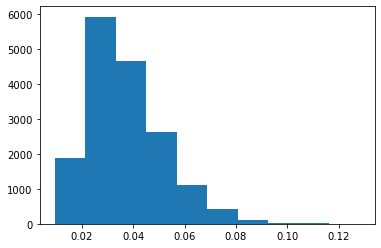

In [11]:
df = pd.DataFrame(test_predictions['probs'].numpy())

for i in range(len(df.columns)-1):
    df[str(i)+"->"+str(i+1)] = df[i+1] - df[i]
    
plt.hist(df["0->1"])

<BarContainer object of 12 artists>

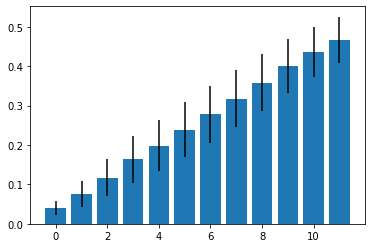

In [14]:
plt.bar(range(12), df[list(range(12))].mean(), yerr=df[list(range(12))].std())

<BarContainer object of 12 artists>

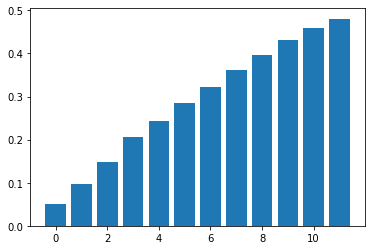

In [24]:
plt.bar(range(12), df[list(range(12))].iloc[500])

In [34]:
splits

NameError: name 'splits' is not defined

In [31]:
test_predictions['golds'][200]

tensor(0)

In [55]:
probs = []

for i, exam in enumerate(test_predictions['exams']):
    split = exam2split[exam.item()]
    if split != 'test':
        continue
    probs.append(test_predictions['probs'][i])
probs = torch.stack(probs)

In [58]:
len(probs)

2530

<BarContainer object of 12 artists>

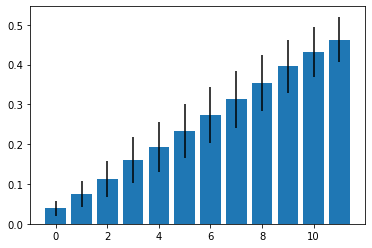

In [59]:
df = pd.DataFrame(probs.numpy())

for i in range(len(df.columns)-1):
    df[str(i)+"->"+str(i+1)] = df[i+1] - df[i]

plt.bar(range(12), df[list(range(12))].mean(), yerr=df[list(range(12))].std())

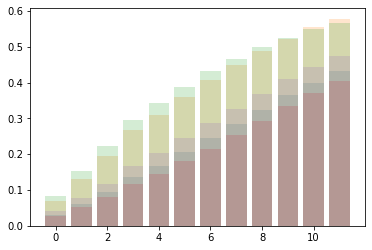

In [80]:
for i in range(5):
    plt.bar(range(12), df[list(range(12))].iloc[i], alpha=0.2)